<a href="https://colab.research.google.com/github/divyanshuraj6815/eva/blob/master/Experiment%2015/experiment_15_with_libraries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -r beginners_library
!git clone https://github.com/divyanshuraj6815/beginners_library.git

Cloning into 'beginners_library'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 45 (delta 11), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [2]:
import numpy as np
import time, math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from beginners_library.data import random_cutout, random_crop, horizontal_flip, write_tf_records, decode
from beginners_library.model import DavidNet

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

write_tf_records (x_train, y_train, 'cifar10.tfrecords')

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (random_cutout (horizontal_flip (random_crop(x, [32, 32, 3])), 32, 32, 8, True), y)

In [7]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
train_graph = {'epochs' : [], 'train_acc' : [], 'train_loss' : [], 'val_acc' : [], 'val_loss' : [], 'learning_rate' : [], 'time_taken' : []}

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  dataset = tf.data.TFRecordDataset ('cifar10.tfrecords')
  train_set = dataset.map (decode).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  
  train_graph['epochs'].append (epoch + 1)
  train_graph['train_loss'].append (train_loss / len_train)  
  train_graph['train_acc'].append (train_acc / len_train)  
  train_graph['val_loss'].append (test_loss / len_test)  
  train_graph['val_acc'].append (test_acc / len_test)  
  train_graph['learning_rate'].append (lr_schedule(epoch+1)) 
  train_graph['time_taken'].append (str (time.time() - t))

  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.6524586462402344 train acc: 0.40104 val loss: 1.1210801086425781 val acc: 0.6001 time: 70.49813652038574



epoch: 2 lr: 0.16 train loss: 0.911560277709961 train acc: 0.67746 val loss: 1.0653276000976561 val acc: 0.6392 time: 117.21282839775085



epoch: 3 lr: 0.24 train loss: 0.7497185284423828 train acc: 0.73664 val loss: 0.7952445053100586 val acc: 0.7296 time: 163.67595553398132



epoch: 4 lr: 0.32 train loss: 0.6005180438232421 train acc: 0.79262 val loss: 0.6577628768920899 val acc: 0.7703 time: 210.58120846748352



epoch: 5 lr: 0.4 train loss: 0.5216235488891602 train acc: 0.82068 val loss: 0.5517224975585937 val acc: 0.8213 time: 257.0202867984772



epoch: 6 lr: 0.37894736842105264 train loss: 0.4248936633300781 train acc: 0.852 val loss: 0.7395862655639649 val acc: 0.7787 time: 303.515504360199



epoch: 7 lr: 0.35789473684210527 train loss: 0.362143948059082 train acc: 0.87482 val loss: 0.41246911239624023 val acc: 0.8598 time: 349.4260182380676



epoch: 8 lr: 0.33684210526315794 train loss: 0.3690699038696289 train acc: 0.87016 val loss: 0.3754339569091797 val acc: 0.876 time: 395.2638854980469



epoch: 9 lr: 0.31578947368421056 train loss: 0.28289496490478516 train acc: 0.90214 val loss: 0.369596996307373 val acc: 0.8787 time: 440.93073201179504



epoch: 10 lr: 0.2947368421052632 train loss: 0.27636265197753906 train acc: 0.9036 val loss: 0.3884039237976074 val acc: 0.8718 time: 486.8772394657135



epoch: 11 lr: 0.2736842105263158 train loss: 0.2387791650390625 train acc: 0.91798 val loss: 0.469159326171875 val acc: 0.853 time: 532.5072829723358



epoch: 12 lr: 0.25263157894736843 train loss: 0.1938872262573242 train acc: 0.93294 val loss: 0.3498345687866211 val acc: 0.8835 time: 578.0569243431091



epoch: 13 lr: 0.23157894736842108 train loss: 0.17118075019836426 train acc: 0.94032 val loss: 0.36371627044677735 val acc: 0.8859 time: 623.6062018871307



epoch: 14 lr: 0.2105263157894737 train loss: 0.14948121170043946 train acc: 0.94854 val loss: 0.38717146224975585 val acc: 0.8783 time: 669.1780650615692



epoch: 15 lr: 0.18947368421052635 train loss: 0.13040562393188476 train acc: 0.9543 val loss: 0.33317615127563477 val acc: 0.9 time: 714.8816316127777



epoch: 16 lr: 0.16842105263157897 train loss: 0.21931500442504884 train acc: 0.92156 val loss: 0.3447030334472656 val acc: 0.8934 time: 760.3375203609467



epoch: 17 lr: 0.1473684210526316 train loss: 0.10929220634460449 train acc: 0.96362 val loss: 0.26759383239746093 val acc: 0.913 time: 805.911877155304



epoch: 18 lr: 0.12631578947368421 train loss: 0.0927173157119751 train acc: 0.96924 val loss: 0.2735800765991211 val acc: 0.9163 time: 851.2428922653198



epoch: 19 lr: 0.10526315789473689 train loss: 0.08056217029571533 train acc: 0.9727 val loss: 0.2683889846801758 val acc: 0.9189 time: 897.099799156189



epoch: 20 lr: 0.08421052631578951 train loss: 0.11740077781677247 train acc: 0.95904 val loss: 0.25334923706054685 val acc: 0.9202 time: 942.287027835846



epoch: 21 lr: 0.06315789473684214 train loss: 0.09276359592437744 train acc: 0.96808 val loss: 0.2670827049255371 val acc: 0.9209 time: 988.0348062515259



epoch: 22 lr: 0.04210526315789476 train loss: 0.07787058990478515 train acc: 0.97384 val loss: 0.2489989028930664 val acc: 0.9228 time: 1033.461267709732



epoch: 23 lr: 0.02105263157894738 train loss: 0.10749964412689209 train acc: 0.96228 val loss: 0.2517961387634277 val acc: 0.9235 time: 1079.0117809772491



epoch: 24 lr: 0.0 train loss: 0.04671127063751221 train acc: 0.98576 val loss: 0.231966060256958 val acc: 0.9266 time: 1124.4262990951538


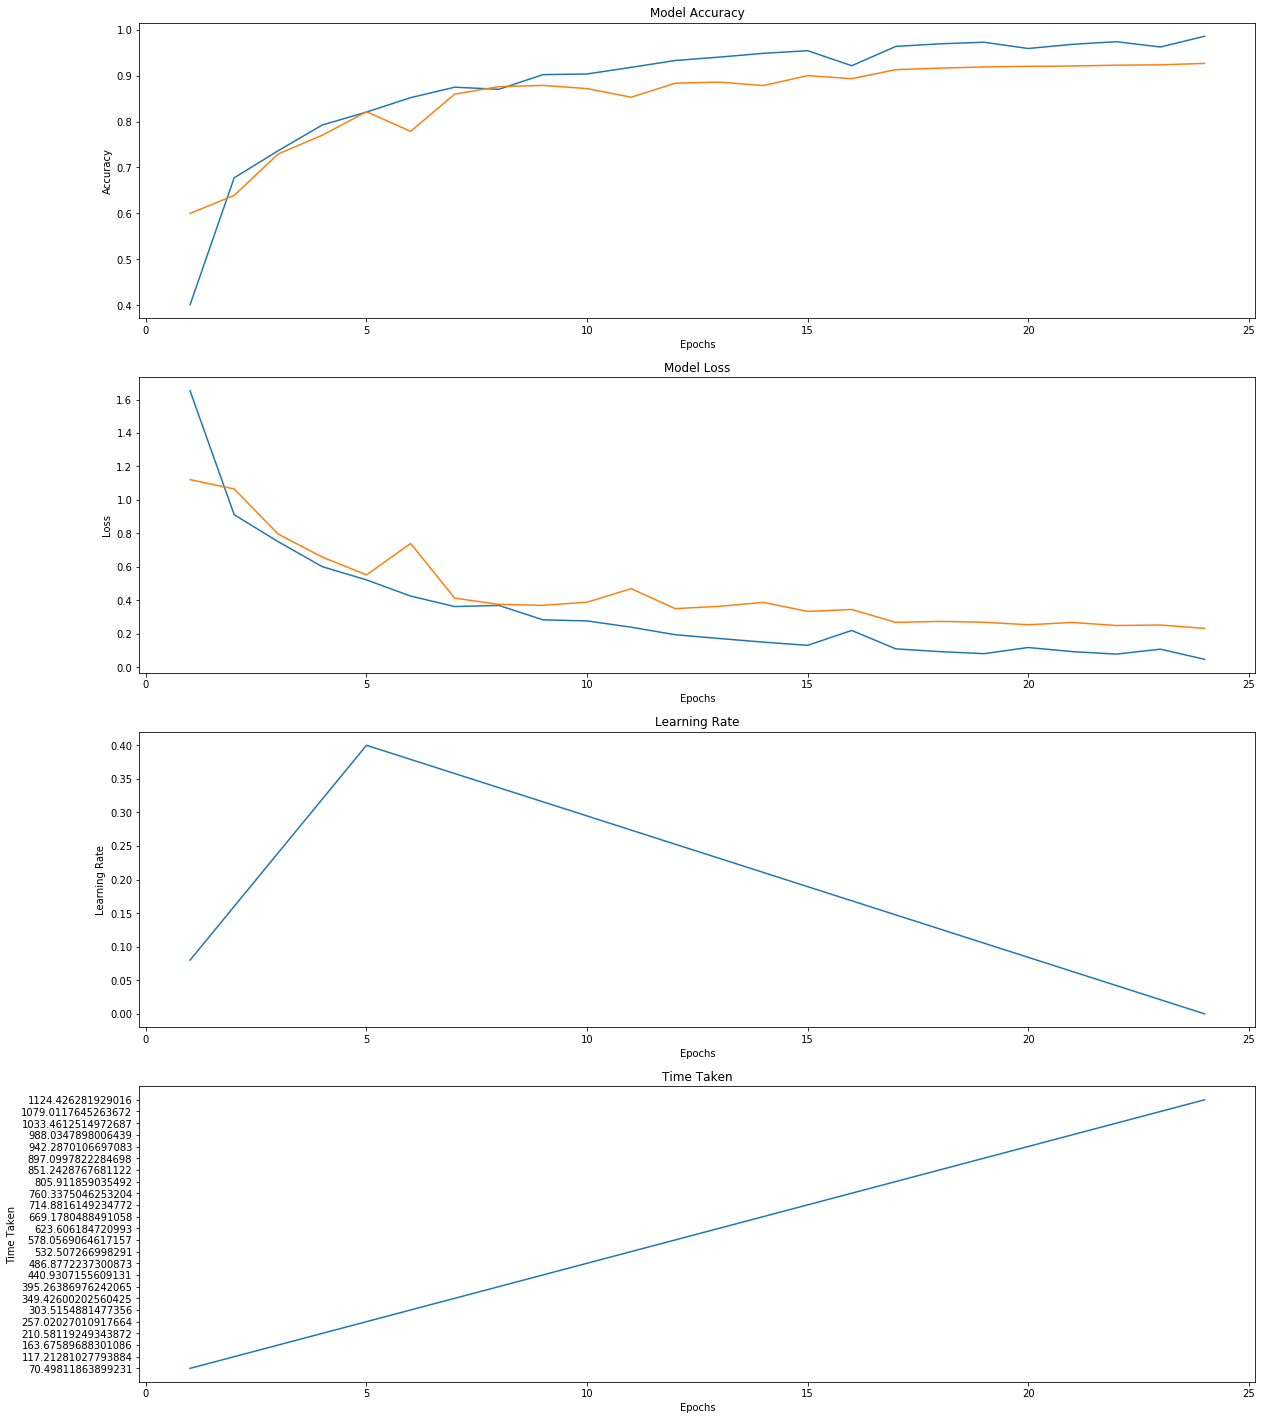

In [8]:
plt.figure (figsize=(20,25))
plt.subplot (411)
plt.title ('Model Accuracy')
plt.xlabel ('Epochs')
plt.ylabel ('Accuracy')
plt.plot (train_graph['epochs'], train_graph['train_acc'], train_graph['epochs'], train_graph['val_acc'])

plt.subplot (412)
plt.title ('Model Loss')
plt.xlabel ('Epochs')
plt.ylabel ('Loss')
plt.plot (train_graph['epochs'], train_graph['train_loss'], train_graph['epochs'], train_graph['val_loss'])

plt.subplot (413)
plt.title ('Learning Rate')
plt.xlabel ('Epochs')
plt.ylabel ('Learning Rate')
plt.plot (train_graph['epochs'], train_graph['learning_rate'])

plt.subplot (414)
plt.title ('Time Taken')
plt.xlabel ('Epochs')
plt.ylabel ('Time Taken')
plt.plot (train_graph['epochs'], train_graph['time_taken'])

plt.show ()